In [86]:
import numpy as np
import pandas as pd # read_csv, get_dumies(원핫인코딩)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # 훈련셋과 시험셋 나누기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt
from tensorflow.keras.activations import relu, softmax # activation='relu' 대신 사용

- Red Wine 품질 등급 예측

```
1. 데이터 셋 확보 & 전처리
    독립변수, 종속변수 분리 -> 독립변수 스케일조정(StandardScaler), 종속변수 원핫인코딩(get_dummies, 훈련셋과 테스트셋 분리(train_test_split)
2. 모델 구성(입력11, 출력6) layer층 4
3. 모델 학습 과정 설정(다중분류에 맞는 설정)
4. 학습시키기 (callbacks이용)
5. 모델 평가 - 그래프, 평가(테스트셋), 교차표
6. 모델 저장 및 모델사용하기
```

In [2]:
redwine = pd.read_csv('data/winequality-red.csv',sep=';')
redwine.quality.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [3]:
display(redwine.head())
print(redwine.info())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


## 1. 데이터 셋 확보 & 전처리
    독립변수, 종속변수 분리 -> 독립변수 스케일조정(StandardScaler), 종속변수 원핫인코딩(get_dummies, 훈련셋과 테스트셋 분리(train_test_split)

In [93]:
X = redwine.iloc[:,:-1]
Y = redwine.iloc[:,-1]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
incoded_Y = pd.get_dummies(Y)

X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, incoded_Y,
                                                    test_size= 0.2,
                                                    random_state=42,
                                                    stratify=incoded_Y
                                                   )
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1279, 11), (320, 11), (1279, 6), (320, 6))

## 2. 모델 구성(입력11, 출력6) layer층 4

In [94]:
model = Sequential()
model.add(Input(shape=(11,)))
model.add(Dense(units=64, activation=relu))
model.add(Dropout(0.1))
model.add(Dense(units=128, activation=relu))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation=relu))
model.add(Dropout(0.1))
model.add(Dense(units=6, activation=softmax))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 64)                768       
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 128)               8320      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 32)                4128      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_43 (Dense)            (None, 6)               

## 3. 모델 학습 과정 설정(다중분류에 맞는 설정)

In [95]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

## 4. 학습시키기 (callbacks이용)

In [96]:
class CustomHistory(Callback):
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%10 == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_accuracy:{}'.\
                 format(self.epoch,
                        logs.get('loss'),
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                       ))
        
earlyStopping = EarlyStopping(patience=40)
customHistory = CustomHistory()

hist = model.fit(X_train, Y_train, epochs=1200, batch_size=100,
                 validation_split=0.2,
                 verbose=0,
                 callbacks=[earlyStopping, customHistory]
                )
print(f'epoch:{hist.epoch[-1]}', end=', ')
for i in hist.history:
    print(f'{i}:',end='')
    if(i!='val_accuracy'):
        print(hist.history[i][-1],end=', ')
    else :
        print(hist.history[i][-1])

epoch:10, loss:0.9627922177314758, acc:0.5982404947280884, val_loss:1.1236441135406494, val_accuracy:0.57421875
epoch:20, loss:0.8698556423187256, acc:0.6344085931777954, val_loss:1.0828572511672974, val_accuracy:0.5859375
epoch:30, loss:0.838016927242279, acc:0.6529814004898071, val_loss:1.0644594430923462, val_accuracy:0.5859375
epoch:40, loss:0.7934032082557678, acc:0.6608015894889832, val_loss:1.055920958518982, val_accuracy:0.5859375
epoch:50, loss:0.7648773193359375, acc:0.6862170100212097, val_loss:1.0533859729766846, val_accuracy:0.61328125
epoch:60, loss:0.7352193593978882, acc:0.6999022364616394, val_loss:1.1202058792114258, val_accuracy:0.6015625
epoch:70, loss:0.7137203812599182, acc:0.7116324305534363, val_loss:1.1194508075714111, val_accuracy:0.59765625
epoch:80, loss:0.6815087795257568, acc:0.7184750437736511, val_loss:1.1560810804367065, val_accuracy:0.59765625
epoch:84, loss:0.6574539542198181, accuracy:0.7321603298187256, val_loss:1.1415830850601196, val_accuracy:0.60

## 5. 모델 평가 - 그래프, 평가(테스트셋), 교차표

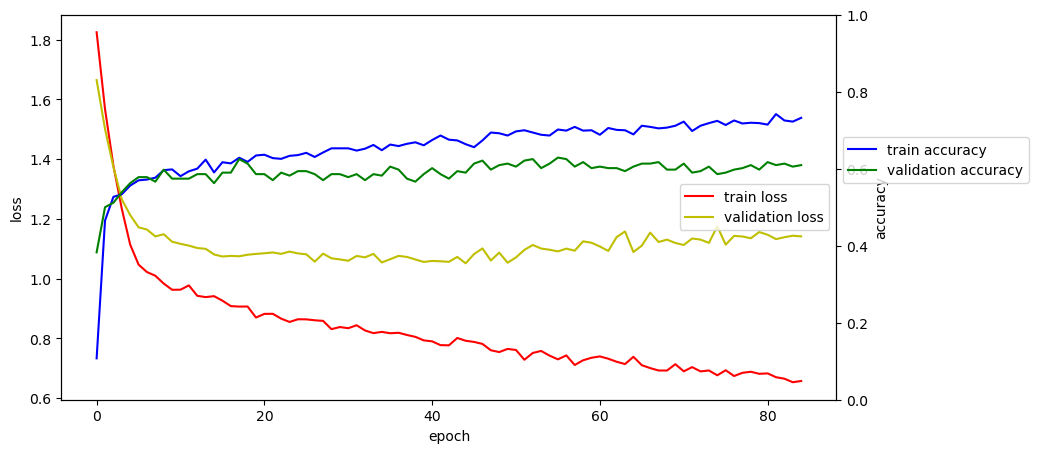

In [97]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylim(0.0,1.0)
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [79]:
y_hat = model.predict(X_test).argmax(axis=1)+3
y_hat

10/10 [==============================] - 0s 1ms/step


array([5, 5, 6, 5, 6, 5, 5, 5, 6, 6, 7, 5, 6, 5, 5, 7, 6, 6, 7, 5, 5, 5,
       6, 7, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 5, 6, 5,
       6, 6, 7, 6, 5, 6, 5, 5, 6, 7, 5, 5, 6, 5, 6, 5, 5, 6, 5, 5, 7, 5,
       7, 5, 7, 5, 6, 5, 6, 6, 6, 5, 7, 5, 5, 7, 5, 7, 5, 5, 6, 6, 5, 6,
       7, 5, 6, 7, 5, 6, 5, 5, 5, 6, 5, 6, 5, 5, 6, 6, 6, 6, 6, 5, 4, 5,
       7, 5, 7, 5, 5, 7, 6, 5, 5, 6, 6, 6, 6, 5, 5, 5, 7, 5, 5, 6, 6, 5,
       5, 7, 6, 5, 5, 5, 5, 6, 7, 6, 7, 5, 6, 5, 6, 5, 5, 5, 6, 7, 5, 6,
       6, 6, 5, 6, 5, 6, 7, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 7, 6,
       6, 5, 5, 5, 5, 7, 5, 7, 5, 7, 6, 6, 7, 5, 6, 7, 5, 6, 6, 5, 5, 5,
       6, 6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 7, 5, 6, 6, 7, 6, 6, 5, 6, 5,
       5, 6, 7, 6, 5, 5, 5, 7, 5, 5, 5, 5, 6, 6, 6, 6, 5, 6, 6, 5, 6, 5,
       6, 6, 6, 7, 6, 5, 7, 5, 6, 5, 5, 6, 6, 5, 5, 6, 6, 7, 7, 6, 5, 7,
       6, 7, 5, 5, 6, 6, 5, 6, 5, 5, 6, 5, 6, 7, 6, 5, 7, 5, 5, 5, 5, 6,
       5, 6, 5, 4, 5, 7, 6, 5, 5, 6, 5, 7, 6, 7, 5,

In [80]:
ctab = pd.crosstab(Y_test.values.argmax(axis=1)+3,y_hat)
ctab.index.name='real'
ctab.columns.name='predict'
ctab

predict,4,5,6,7
real,,,,
3,0,1,0,0
4,0,8,2,0
5,0,97,31,2
6,2,49,62,19
7,0,1,20,21
8,0,0,0,5


In [81]:
model.evaluate(X_test, Y_test)

10/10 [==============================] - 0s 1ms/step - loss: 0.9106 - accuracy: 0.5625


[0.9105775952339172, 0.5625]

## 6. 모델 저장 및 모델사용하기

In [82]:
model.save('model/wine.h5')

In [83]:
from tensorflow.keras.models import load_model
model2 = load_model('model/wine.h5')
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                768       
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 32)                4128      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 6)                

In [84]:
model_json = model.to_json()
with open('model/wine.json','w') as f:
    f.write(model_json)

In [85]:
with open('model/wine.json','r') as f:
    model_json2 = f.read()
from tensorflow.keras.models import model_from_json
model3 = model_from_json(model_json2)
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                768       
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 32)                4128      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 6)                